In [1]:
import matplotlib.pyplot as plt
import autograd.numpy as np

from matplotlib.colors import LogNorm
from matplotlib import animation
from IPython.display import HTML

from autograd import elementwise_grad, value_and_grad
from scipy.optimize import minimize
from collections import defaultdict
from itertools import izip_longest
from functools import partial

from mpl_toolkits.mplot3d import axes3d, Axes3D
from matplotlib import cm

In [2]:
# All from http://tiao.io/notes/visualizing-and-animating-optimization-algorithms-with-matplotlib/

def make_minimize_cb(path=[]):
    def minimize_cb(xk):
        path.append(np.copy(xk))
    return minimize_cb

def init3d():
    line.set_data([], [])
    line.set_3d_properties([])
    point.set_data([], [])
    point.set_3d_properties([])
    return line, point

def animate3d(i):
    line.set_data(path[0,:i], path[1,:i])
    line.set_3d_properties(f(*path[::,:i]))
    point.set_data(path[0,i-1:i], path[1,i-1:i])
    point.set_3d_properties(f(*path[::,i-1:i]))
    return line, point

In [3]:
def f(x, y):
    return (x**2 + y**2) + (0.5*x + y)**2 + (0.5*x + y)**4

minima = np.array([0, 0])
start_point = np.array([8, 8])
minima_ = minima.reshape(-1, 1)

xmin, xmax = -10, 10
ymin, ymax = -10, 10

In [4]:
f(*minima)

0.0

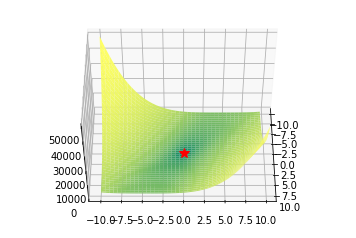

In [5]:
fig = plt.figure()
ax = fig.gca(projection='3d', elev=50, azim=0)
ax.plot([minima[0]], [minima[1]], 'r*', markersize=10)

# Make data.
X = np.arange(xmin, xmax, 0.25)
Y = np.arange(ymin, ymax, 0.25)
X, Y = np.meshgrid(X, Y)
Z = f(X, Y)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.summer,
                       linewidth=0, antialiased=True, norm=LogNorm())
plt.show()

In [6]:
dz_dx = elementwise_grad(f, argnum=0)(X, Y)
dz_dy = elementwise_grad(f, argnum=1)(X, Y)

/anaconda2/lib/python2.7/site-packages/matplotlib/contour.py:1537: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


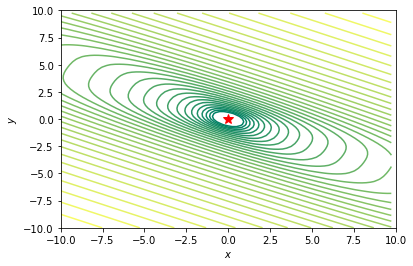

In [7]:
fig, ax = plt.subplots()

ax.contour(X, Y, Z, levels=np.logspace(0, 5, 35), cmap=cm.summer, norm = LogNorm())
# ax.quiver(X, Y, X - dz_dx, Y - dz_dy, alpha=.5)
ax.plot([minima[0]], [minima[1]], 'r*', markersize=10)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

plt.show()

In [8]:
f_g = value_and_grad(lambda args: f(*args))

methods = [
    "CG",
    "Newton-CG",
    "L-BFGS-B",
    "TNC",
    "SLSQP",
]

# methods = ['Nelder-Mead', 'Powell']


minimize_ = partial(minimize, fun=f_g, x0=start_point, jac=True, bounds=[(xmin, xmax), (ymin, ymax)], tol=1e-20)

paths_ = defaultdict(list)
for method in methods:
    paths_[method].append(start_point)
    
results = {method: minimize_(method=method, callback=make_minimize_cb(paths_[method])) for method in methods}

paths = [np.array(paths_[method]).T for method in methods]

zpaths = [f(*path) for path in paths]

/anaconda2/lib/python2.7/site-packages/scipy/optimize/_minimize.py:430: RuntimeWarning: Method CG cannot handle constraints nor bounds.
  RuntimeWarning)
/anaconda2/lib/python2.7/site-packages/scipy/optimize/_minimize.py:430: RuntimeWarning: Method Newton-CG cannot handle constraints nor bounds.
  RuntimeWarning)


In [9]:
class TrajectoryAnimation(animation.FuncAnimation):
    
    def __init__(self, paths, labels=[], fig=None, ax=None, frames=None, 
                 interval=60, repeat_delay=5, blit=True, **kwargs):

        if fig is None:
            if ax is None:
                fig, ax = plt.subplots()
            else:
                fig = ax.get_figure()
        else:
            if ax is None:
                ax = fig.gca()

        self.fig = fig
        self.ax = ax
        
        self.paths = paths

        if frames is None:
            frames = max(path.shape[1] for path in paths)
  
        self.lines = [ax.plot([], [], label=label, lw=2)[0] 
                      for _, label in izip_longest(paths, labels)]
        self.points = [ax.plot([], [], 'o', color=line.get_color())[0] 
                       for line in self.lines]

        super(TrajectoryAnimation, self).__init__(fig, self.animate, init_func=self.init_anim,
                                                  frames=frames, interval=interval, blit=blit,
                                                  repeat_delay=repeat_delay, **kwargs)

    def init_anim(self):
        for line, point in zip(self.lines, self.points):
            line.set_data([], [])
            point.set_data([], [])
        return self.lines + self.points

    def animate(self, i):
        for line, point, path in zip(self.lines, self.points, self.paths):
            line.set_data(*path[::,:i])
            point.set_data(*path[::,i-1:i])
        return self.lines + self.points

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.contour(X, Y, Z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=cm.gray)
ax.plot([minima[0]], [minima[1]], 'r*', markersize=10)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

anim = TrajectoryAnimation(paths, labels=methods, ax=ax)

ax.legend(loc='upper left')


# HTML(anim.to_html5_video())
anim.save('./gifs1/zakharov2.gif', dpi=80, writer='imagemagick')

In [11]:
class TrajectoryAnimation3D(animation.FuncAnimation):
    
    def __init__(self, paths, zpaths, labels=[], fig=None, ax=None, frames=None, 
                 interval=60, repeat_delay=5, blit=True, **kwargs):

        if fig is None:
            if ax is None:
                fig, ax = plt.subplots()
            else:
                fig = ax.get_figure()
        else:
            if ax is None:
                ax = fig.gca()

        self.fig = fig
        self.ax = ax
        
        self.paths = paths
        self.zpaths = zpaths
        
        if frames is None:
            frames = max(path.shape[1] for path in paths)
  
        self.lines = [ax.plot([], [], [], label=label, lw=2)[0] 
                      for _, label in izip_longest(paths, labels)]

        super(TrajectoryAnimation3D, self).__init__(fig, self.animate, init_func=self.init_anim,
                                                  frames=frames, interval=interval, blit=blit,
                                                  repeat_delay=repeat_delay, **kwargs)

    def init_anim(self):
        for line in self.lines:
            line.set_data([], [])
            line.set_3d_properties([])
        return self.lines

    def animate(self, i):
        for line, path, zpath in zip(self.lines, self.paths, self.zpaths):
            line.set_data(*path[::,:i])
            line.set_3d_properties(zpath[:i])
        return self.lines

In [13]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d', elev=50, azim=150)

ax.plot_surface(X, Y, Z, norm=LogNorm(), edgecolor='none', alpha=.8, cmap=plt.cm.gray)
ax.plot([minima[0]], [minima[1]], 'r*', markersize=10)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

anim = TrajectoryAnimation3D(paths, zpaths=zpaths, labels=methods, ax=ax)

ax.legend(loc='upper left')


# HTML(anim.to_html5_video())
anim.save('./gifs1/zakharov1.gif', dpi=80, writer='imagemagick')